In [ ]:
!pip install pydotplus

# Machine Learning
The discipline of creating machines able to learn.

- Learn what? A model
- To solve what? A task
- Learn how? By using a learning algorithm
- Learning by? Searching

In [21]:
from datasets import load_dataset


dataset = load_dataset("mstz/adult", "income")["train"].to_pandas()
test_dataset = load_dataset("mstz/adult", "income")["test"].to_pandas()

train_labels = dataset["over_threshold"]
test_labels = test_dataset["over_threshold"]

dataset = dataset.drop("over_threshold", axis="columns")
test_dataset = test_dataset.drop("over_threshold", axis="columns")

# Preprocessing
Scaling allows us to transform data so that it is more amenable to some uses, e.g., discretization for data understanding.
Some algorithms are particularly sensitive to data, e.g., they are sensitive to sparse data or data with features at different scale.

In [22]:
from sklearn.preprocessing import StandardScaler
import pandas


numeric_dataset = dataset.select_dtypes(include="number")
numeric_test_dataset = test_dataset.select_dtypes(include="number")
joined_full_dataset = pandas.concat((dataset, test_dataset), axis="rows")

# scaling with unit scaling
scaler = StandardScaler()
joined_numeric_dataset = pandas.concat((numeric_dataset, numeric_test_dataset), axis="rows")
scaled_full_numeric_dataset = scaler.fit_transform(joined_numeric_dataset.values)

scaled_numeric_dataset = scaled_full_numeric_dataset[:numeric_dataset.shape[0]]
scaled_numeric_test_dataset = scaled_full_numeric_dataset[numeric_dataset.shape[0]:]

# Encoding
Some learning algorithms may not be suitable to deal with some features, e.g., categorical data.
In these cases, we can encode such features in a better fitting format.

Categorical encoding:
- one-hot: a `c`-long vector of zeros, where the i-th entry is set to `1` if it belongs to the i-th category
- target encoding: empirical probability of that category being of the given class

#### One-hot encoding example
For a feature `animal` with possible values `cat`, `dog`:
- a value `cat` is encoded as `<1, 0>`
- a value `dog` is encoded as `<0, 1>`

In [31]:
from sklearn.preprocessing import OneHotEncoder


categorical_features_only = joined_full_dataset.select_dtypes(exclude="number")

encoder = OneHotEncoder()
one_hot_encoded_dataframes = []
# encode feature by feature
for feature in categorical_features_only.columns:
    print(f"Encoding {feature}")
    transformed_data = encoder.fit_transform(categorical_features_only[[feature]]).toarray()
    transformed_columns = encoder.get_feature_names_out()
    one_hot_encoded_dataframes = one_hot_encoded_dataframes + [pandas.DataFrame(transformed_data,
                                                                               columns=transformed_columns)]

fully_encoded_dataset = pandas.concat(one_hot_encoded_dataframes, axis="columns")
fully_encoded_train_dataset = pandas.concat((numeric_dataset, fully_encoded_dataset.loc[:dataset.shape[0]]), axis="columns")
fully_encoded_test_dataset = pandas.concat((numeric_test_dataset, fully_encoded_dataset.loc[:dataset.shape[0]]), axis="columns")

fully_encoded_train_dataset.head()

Encoding marital_status
Encoding native_country
Encoding occupation
Encoding race
Encoding relationship
Encoding is_male
Encoding workclass


,age,capital_gain,capital_loss,education,final_weight,hours_worked_per_week,marital_status_Divorced,marital_status_Married-AF-spouse,marital_status_Married-civ-spouse,marital_status_Married-spouse-absent,...,is_male_True,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay
0,43.0,0.0,0.0,10.0,34278.0,35.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,23.0,0.0,0.0,3.0,244698.0,35.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,39.0,0.0,0.0,10.0,118286.0,40.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,35.0,0.0,0.0,9.0,126675.0,46.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,66.0,0.0,0.0,13.0,28367.0,99.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# Solution space and hyperparameters

First, we need to decide what famil our model will belong to:
- Decision Trees
- Random Forests
- Neural Network
- Support Vector Machine
- ...

Each learning algorithm can be characterized by a set of hyperparameters, e.g., the architecture of a neural network, that must be set in order to learn a model.
Searching through this hyperparameter space requires a **search policy**.

In [48]:
from sklearn.model_selection import GridSearchCV  # for exhaustive search
from sklearn.model_selection import RandomizedSearchCV  # for randomized search
from sklearn.tree import DecisionTreeClassifier


tree = LinearSVC()
hyperparameters = {
    "max_depth": [3, 4, 5, 6, 7, 8],
    "criterion": ["gini", "entropy"]
}


search = RandomizedSearchCV(tree, hyperparameters)
search.fit(scaled_numeric_dataset, train_labels)
tree = search.best_estimator_

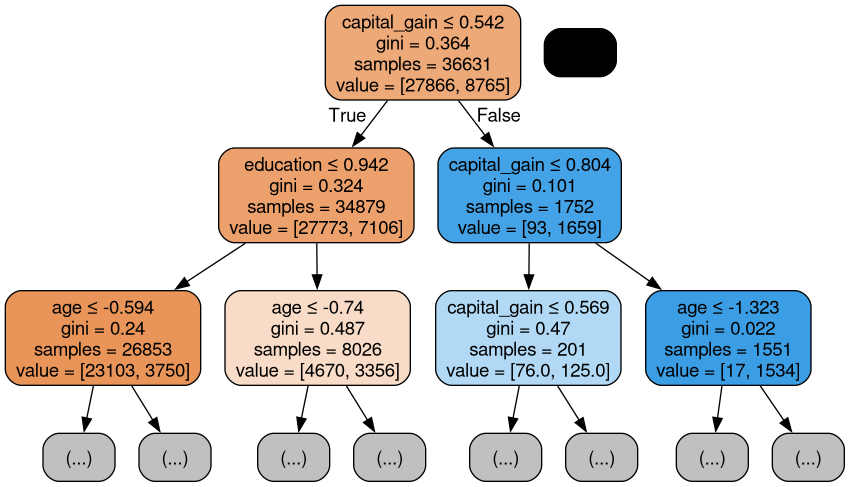

In [55]:
import pydotplus
from sklearn.tree import export_graphviz
from IPython.display import Image


dot_data = export_graphviz(tree, out_file=None,
                           feature_names=numeric_dataset.columns,
                           filled=True, rounded=True,
                           special_characters=True,
                           max_depth=2)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

# Validation
Model validation allows us to assess the ability of the model to generalize.
It consists of a set of metrics which measure the performance of the model on an held-out test set of data which the model has never seen.

#### Some metrics
- accuracy: proportion of correct predictions
- precision: proportion of true positives to positive predictions
- recall: proportion of true positives to all positives
- f1: harmonic mean of precision and recall

In [53]:
from sklearn.metrics import classification_report


train_predictions = tree.predict(scaled_numeric_dataset)
test_predictions = tree.predict(scaled_numeric_test_dataset)

report = classification_report(test_labels, test_predictions, output_dict=True)
report

{'0': {'precision': 0.8441215323645971,
  'recall': 0.9630746043707611,
  'f1-score': 0.8996832101372756,
  'support': 9289.0},
 '1': {'precision': 0.78735275883447,
  'recall': 0.4346338124572211,
  'f1-score': 0.5600882028665931,
  'support': 2922.0},
 'accuracy': 0.8366227172221767,
 'macro avg': {'precision': 0.8157371455995335,
  'recall': 0.698854208413991,
  'f1-score': 0.7298857065019344,
  'support': 12211.0},
 'weighted avg': {'precision': 0.830537193960287,
  'recall': 0.8366227172221767,
  'f1-score': 0.8184206918140479,
  'support': 12211.0}}

# Validation: dos and don'ts
Do:
- try different hyperparameter combinations sensibly, use the exhaustive search only if the hyperparameters change really has an effect and is time-manageable
- try different data preprocessings
- if enough data is available, use a separate dataset for model selection (see [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) for a quick way to do it.)

Don't:
- select your model on the basis of the test set! The test set only *validates*: using it to select a model is cheating!